# Downloading Places356 Trained Resnet50

In [1]:
# PlacesCNN for scene classification
#
# by Bolei Zhou
# last modified by Bolei Zhou, Dec.27, 2017 with latest pytorch and torchvision (upgrade your torchvision please if there is trn.Resize error)

import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
from PIL import Image
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

# th architecture to use
arch = 'resnet50'


In [2]:
# load the pre-trained weights
model_file = '%s_places365.pth.tar' % arch
if not os.access(model_file, os.W_OK):
    weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
    os.system('wget ' + weight_url)

In [3]:
model = models.__dict__[arch](num_classes=365)
checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)

<All keys matched successfully>

# Definng Custom Layers to be used

In [4]:
# method to initialize layer weights with Kaiming Normal
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)
        
# Apply AveragePooling and MaxPooling and conat them
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=None):
        super().__init__()
        sz = sz or (1,1)
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

# Apply function on layer
class Lambda(nn.Module):
    def __init__(self, f): super().__init__(); self.f=f
    def forward(self, x): return self.f(x)

# Flatten Layer
class Flatten(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x): return x.view(x.size(0), -1)
    

# Defining the Model

In [5]:
class SUNClassifier(nn.Module):
    def __init__(self,model):
        super(SUNClassifier,self).__init__()
        
        # Cut the pretrained model before classification layers to get deep features
        head = [m for m in model.children() if not (isinstance(m,nn.AdaptiveAvgPool2d) or isinstance(m,nn.Linear))]
        self.head = nn.Sequential(*head)
        
        # Apply Max Pool and Avg Pool and concat them
        self.pooling = nn.Sequential(AdaptiveConcatPool2d(),Flatten())
        
        # Defing Classification Layers
        self.tail = nn.Sequential(
            nn.BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p=0.25, inplace=False),
            nn.Linear(in_features=4096, out_features=512, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=512, out_features=397, bias=True),   
        )
        
        # Initialze  Classification Layers with Kaiming Normal
        self.tail.apply(init_weights)


            
    def forward(self, x):
        x = self.head(x)
        x = self.pooling(x)
        x = self.tail(x)
        return x

In [6]:
# Initialize the Model

In [7]:
mm = SUNClassifier(model)

In [8]:
mm

SUNClassifier(
  (head): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(6

# Loading Dataset

In [9]:
path = Path('SUN397')

In [10]:
train_df = pd.read_csv('partations/Training_05.txt',names=['img'] )
test_df =  pd.read_csv('partations/Testing_05.txt',names=['img'] )

In [11]:
train_df.shape,test_df.shape

((19850, 1), (19850, 1))

In [12]:
train_df.head()

,img
0,/a/abbey/sun_aqkoegfgyqvketwj.jpg
1,/a/abbey/sun_aowgddbfwuycbznu.jpg
2,/a/abbey/sun_askedxjewutmkwey.jpg
3,/a/abbey/sun_atqevsqpwuskzqje.jpg
4,/a/abbey/sun_aemytrbhywxpeety.jpg


# Getting Labels

In [13]:
train_labels = train_df.img.str.extract('/./([/\w]+)/\w+')
test_labels = test_df.img.str.extract('/./([/\w]+)/\w+')

In [14]:
train_df['label'] = train_labels
train_df['is_valid'] = False

test_df['label'] = test_labels
test_df['is_valid'] = True

In [15]:
df = pd.concat([train_df,test_df])
df.head()

,img,label,is_valid
0,/a/abbey/sun_aqkoegfgyqvketwj.jpg,abbey,False
1,/a/abbey/sun_aowgddbfwuycbznu.jpg,abbey,False
2,/a/abbey/sun_askedxjewutmkwey.jpg,abbey,False
3,/a/abbey/sun_atqevsqpwuskzqje.jpg,abbey,False
4,/a/abbey/sun_aemytrbhywxpeety.jpg,abbey,False


In [16]:
# Get image Augmentations to apply
tfms = get_transforms()
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do

In [17]:
# Read the data
data = (ImageList.from_df(df,path).split_from_df().label_from_df().transform(tfms,size=224)
        .databunch(bs=128)
        .normalize(imagenet_stats))

In [18]:
data

ImageDataBunch;

Train: LabelList (19850 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
abbey,abbey,abbey,abbey,abbey
Path: SUN397;

Valid: LabelList (19850 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
abbey,abbey,abbey,abbey,abbey
Path: SUN397;

Test: None

In [19]:
data.train_dl.c,data.valid_dl.c

(397, 397)

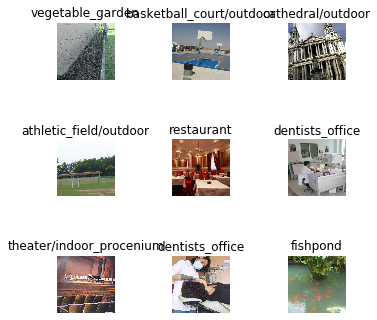

In [20]:
data.show_batch(rows=3, figsize=(5,5))

In [21]:
learner = Learner(data,mm,metrics=[accuracy,error_rate],callback_fns=[partial(CSVLogger, append=True)])

# Divide the model into layer goups to use discriminative learning rates

In [22]:
learner.layer_groups = [learner.layer_groups[0][:57],learner.layer_groups[0][57:124],learner.layer_groups[0][124:]]

# Freeze the pretrained Weights 

In [23]:
learner.freeze()

# Finding optimal learning rate 

In [24]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


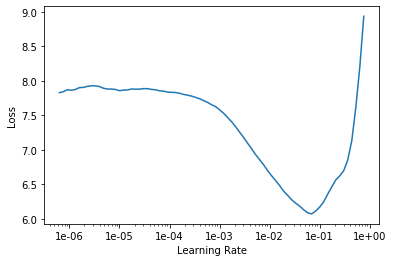

In [25]:
learner.recorder.plot()

# Train the model using one cycle policy

In [26]:
learner.fit_one_cycle(5,3e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,3.053918,1.602363,0.572796,0.427204,07:32
1,2.055854,1.556024,0.587355,0.412645,07:34
2,1.587337,1.293446,0.640353,0.359647,07:34
3,1.196448,1.118837,0.680453,0.319547,07:39
4,0.943023,1.081918,0.692040,0.307960,07:35


# Unfreeze the complete model

In [27]:
learner.unfreeze()

In [28]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


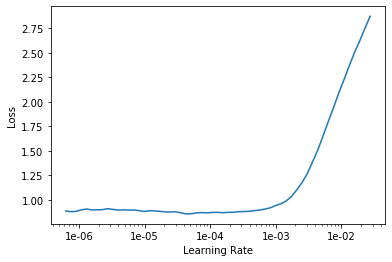

In [29]:
learner.recorder.plot()

In [30]:
learner.fit_one_cycle(3, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.865293,1.080561,0.691839,0.308161,07:41
1,0.841334,1.074188,0.693401,0.306599,07:40
2,0.835416,1.072479,0.693098,0.306902,07:39


In [32]:
learner.freeze()

# Save the Pytorch Model Weight

In [33]:
torch.save(learner.model.state_dict(), 'Resnet50-places-run2.pt') 

In [34]:
#learner.save('stage-1')
learner.save('resnet50-place-run2')

In [35]:
learner.load('resnet50-place-run2')

Learner(data=ImageDataBunch;

Train: LabelList (19850 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
abbey,abbey,abbey,abbey,abbey
Path: SUN397;

Valid: LabelList (19850 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
abbey,abbey,abbey,abbey,abbey
Path: SUN397;

Test: None, model=SUNClassifier(
  (head): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [36]:
learner.validate(metrics=[accuracy])

[1.0724795, tensor(0.6931)]